Import Libraries

In [1]:
# TensorFlow and high-level keras API for deep learning models.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16

# Core layers, preprocessing, and model architectures from TensorFlow's keras.
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Keras callbacks for enhancing model training through early stopping and learning rate adjustments.
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Preprocessing and utility functions from Keras (now integrated into TensorFlow).
from keras.preprocessing.image import img_to_array, load_img
from keras.applications.vgg16 import preprocess_input

# Data visualization libraries for creating plots and statistical graphics.
import matplotlib.pyplot as plt
import seaborn as sns

# Operating system interface for interacting with the operating system.
import os

# Scikit-learn metrics for evaluating model performance.
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# SHAP and LIME for explainable AI, helping to understand model predictions.
from skimage.segmentation import mark_boundaries
from lime import lime_image

# NumPy for numerical operations on arrays and matrices.
import numpy as np

# Pickle module for serializing and deserializing Python object structures.
import pickle

# Import warnings module to suppress warnings, especially deprecation ones.
import warnings
warnings.filterwarnings('ignore')

___
EDA

In [2]:
# Define the base path for the chest x-ray image dataset.
path = "chest_xray/chest_xray"

# Define the paths to the training and testing subdirectories.
train_path = path + '/train'
test_path = path + '/test'

# Calculate the number of 'NORMAL' images in the training directory.
train_norm = len(os.listdir(train_path + '/NORMAL'))
# Calculate the number of 'PNEUMONIA' images in the training directory.
train_pne = len(os.listdir(train_path + '/PNEUMONIA'))
# Print the total number of images in the training set.
print("Total number of images in train set", (train_norm + train_pne))

# Calculate the number of 'NORMAL' images in the testing directory.
test_norm = len(os.listdir(test_path + '/NORMAL'))
# Calculate the number of 'PNEUMONIA' images in the testing directory.
test_pne = len(os.listdir(test_path + '/PNEUMONIA'))
# Print the total number of images in the testing set.
print("Total number of images in test set", (test_norm + test_pne))

# Print an empty line for better readability in output.
print()

# Check if a '.DS_Store' file exists in the training directory.
ds_store_path = os.path.join(train_path, '.DS_Store')
if os.path.exists(ds_store_path):
    # If the file exists, remove it to avoid issues with file operations.
    os.remove(ds_store_path)
    print('.DS_Store has been removed')
else:
    # If the file does not exist, inform the user.
    print('.DS_Store not found in the directory')

# List the contents of the training directory to ensure '.DS_Store' is removed and check the folder structure.
os.listdir(train_path)    

Total number of images in train set 5218
Total number of images in test set 624

.DS_Store not found in the directory


['PNEUMONIA', 'NORMAL']

___
Train and Test Dataset Distribution

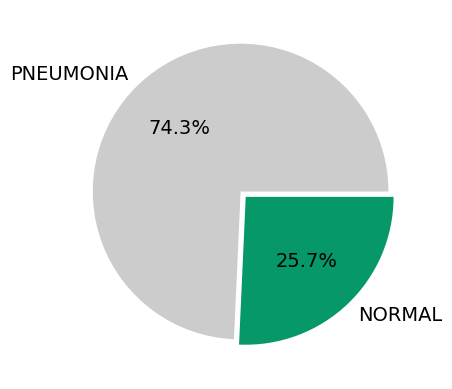

In [3]:
# Initialise empty lists to store the paths to training images and their corresponding labels.
train_paths = []
train_labels = []

# Loop through each label directory in the train_path directory.
for label in os.listdir(train_path):
    # Loop through each image file in the subdirectory of the current label.
    for image in os.listdir(train_path + '/' + label):
        # Append the full path of the image to the train_paths list.
        train_paths.append(train_path + label + '/' + image)
        # Append the label of the image to the train_labels list.
        train_labels.append(label)
        
# Define the colors for the pie chart segments.
colours = ['#CCCCCC', '#069869']  # Light grey for NORMAL, Green for PNEUMONIA
# Update default font size for all elements of the plot for better readability.
plt.rcParams.update({'font.size': 14})
# Create a pie chart to show the percentage distribution of PNEUMONIA vs NORMAL images.
plt.pie([len([x for x in train_labels if x == 'PNEUMONIA']),
         len([x for x in train_labels if x == 'NORMAL'])],
        labels=['PNEUMONIA', 'NORMAL'],
        colors=colours, autopct='%.1f%%', explode=(0.025, 0.025))  # Explode slices for emphasis.
# Display the pie chart.
plt.show()

.DS_Store not found in the directory


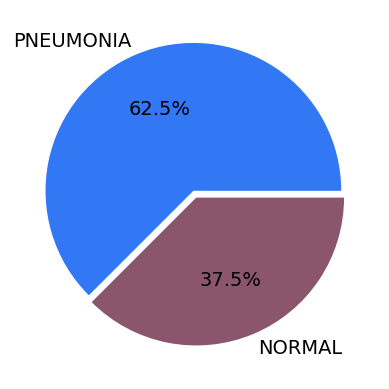

In [4]:
# Initialise empty lists for storing paths to test images and their labels.
test_paths = []
test_labels = []

# Check if '.DS_Store' exists in the test directory and remove it if present.
ds_store_path = os.path.join(test_path, '.DS_Store')
if os.path.exists(ds_store_path):
    os.remove(ds_store_path)
    print('.DS_Store has been removed')  # Notify that the file has been removed.
else:
    print('.DS_Store not found in the directory')  # Notify that the file was not found.

# This appears to be a debugging line, listing the contents of the train_path directory; seems misplaced.
os.listdir(train_path)  

# Loop through each label directory within the test dataset directory.
for label in os.listdir(test_path):
    # Loop through each image file within the label subdirectory.
    for image in os.listdir(test_path + '/' + label):
        # Append the full path of the image to the test_paths list.
        test_paths.append(test_path + label + '/' + image)
        # Append the label (PNEUMONIA or NORMAL) to the test_labels list.
        test_labels.append(label)

# Define the colors for the pie chart segments.
colours = ['#3277f4', '#8b566c']  # Blue for PNEUMONIA, Mauve for NORMAL
# Update the default font size for better readability in plots.
plt.rcParams.update({'font.size': 14})
# Create a pie chart to show the percentage distribution of PNEUMONIA vs NORMAL images in the test dataset.
plt.pie([len([x for x in test_labels if x == 'PNEUMONIA']),
         len([x for x in test_labels if x == 'NORMAL'])],
        labels=['PNEUMONIA', 'NORMAL'],
        colors=colours, autopct='%.1f%%', explode=(0.025, 0.025))  # Explode slices for emphasis.
# Display the pie chart.
plt.show()

(2234, 2359)
(1067, 1422)
(1357, 1828)
(1495, 1854)


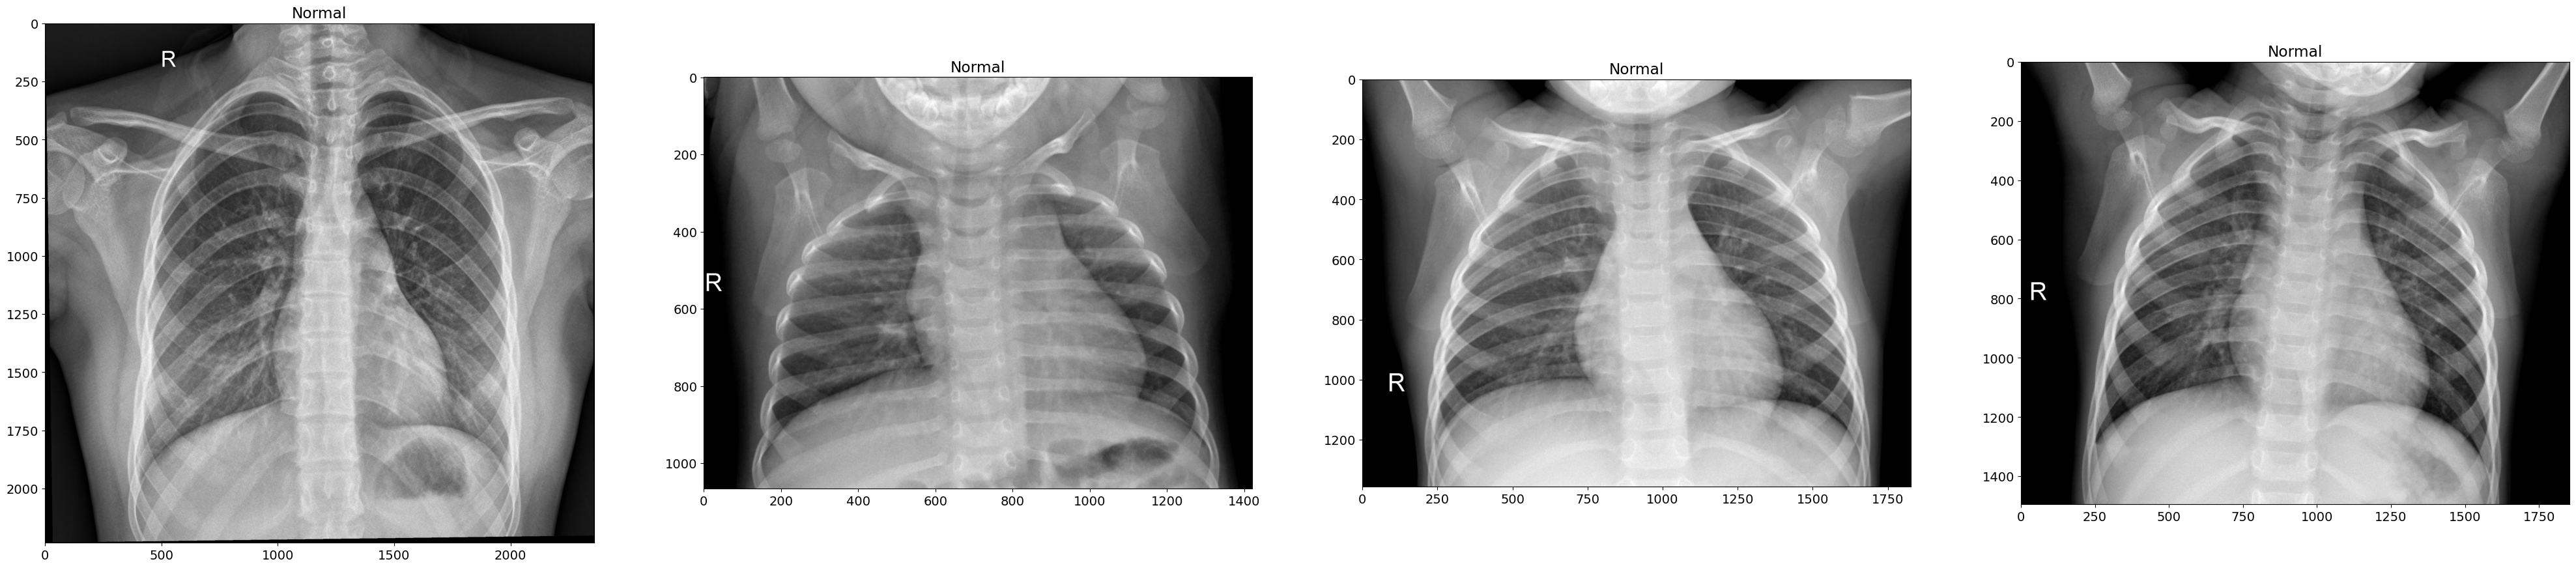

(736, 1048)
(672, 984)
(712, 992)
(888, 1224)


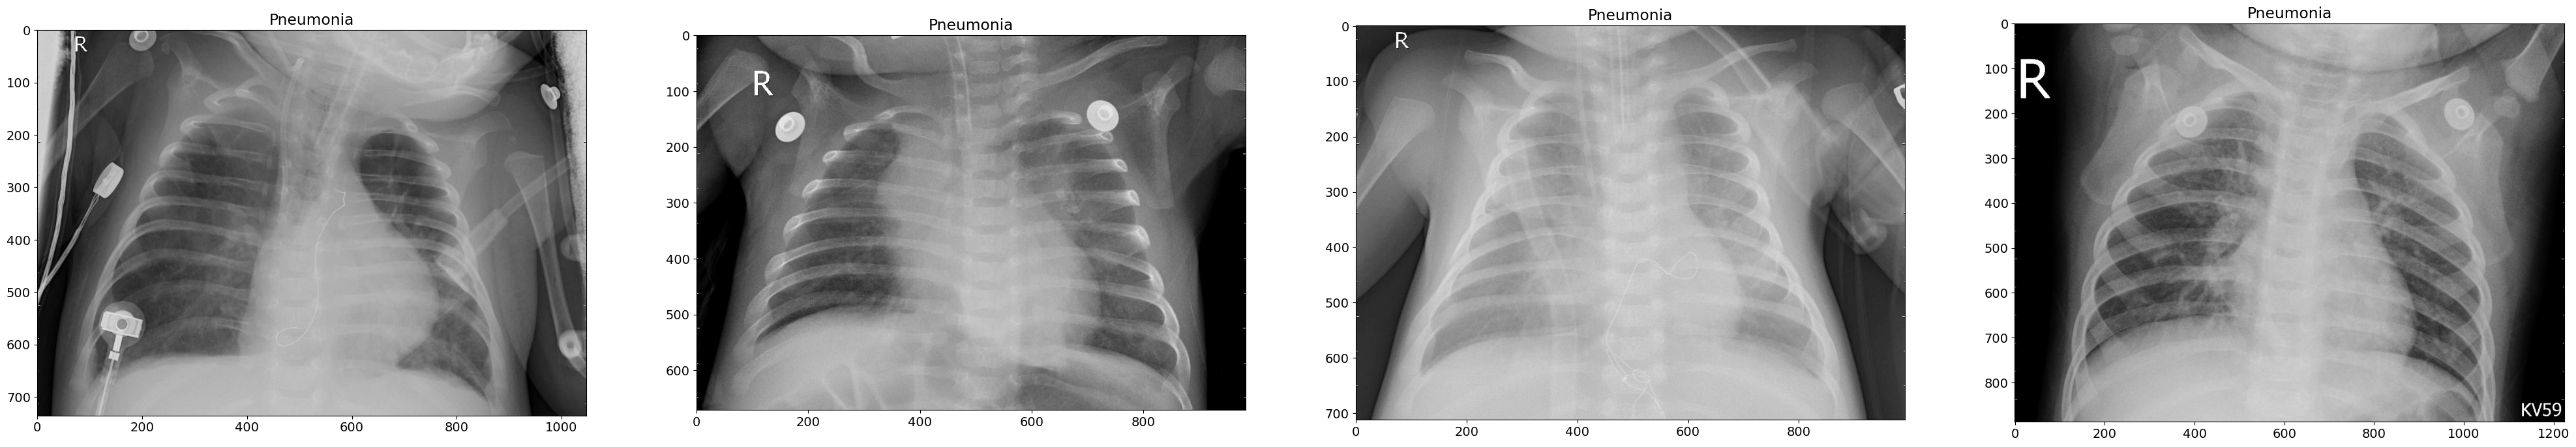

In [5]:
# Define a function to plot images from a given directory.
def plot_image(path, title):
    # List all files in the given directory.
    image_filenames = os.listdir(path)
    # Create a subplot with 1 row and 4 columns; each subplot is quite large.
    fig, axs = plt.subplots(1, 4, figsize=(50,50))
    # Loop over the first four images in the directory.
    for i in range(4):
        # Read each image file.
        image_data = plt.imread(path + '/' + image_filenames[i])
        # Print the shape of the image array to the console (useful for debugging and understanding image dimensions).
        print(image_data.shape)
        # Display the image in the ith subplot and use grayscale coloring.
        axs[i].imshow(image_data, cmap="gray")
        # Set the title for each subplot to indicate the category of the image.
        axs[i].set_title(title)
    # Display the figure with all subplots.
    plt.show()

# Set the path to the folder containing normal x-ray images and plot them.
image_folder_path = train_path + '/NORMAL'
plot_image(image_folder_path, "Normal")

# Set the path to the folder containing pneumonia x-ray images and plot them.
image_folder_path = train_path + '/PNEUMONIA'
plot_image(image_folder_path, "Pneumonia")

___
Image Data Generator

In [6]:
# Define the target shape for the images
image_shape = (128,128,3)

# Create an ImageDataGenerator object with specified data augmentation parameters:
image_gen = ImageDataGenerator(
    rotation_range=20,     # Randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=.1,  # Randomly shift images horizontally (fraction of total width)
    height_shift_range=.1, # Randomly shift images vertically (fraction of total height)
    shear_range = .1,        # Randomly apply shearing transformations
    zoom_range = .1,         # Randomly zoom in on images
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'    # Use the nearest pixels for filling up areas created by the above transformations
)

# Utilise the generator to prepare image data augmentation from the training and testing directory.
image_gen.flow_from_directory(train_path)
image_gen.flow_from_directory(test_path)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [7]:
# Configure the ImageDataGenerator for training data. 
train_image_gen = image_gen.flow_from_directory(
    train_path,                        # Path to the training dataset directory.
    target_size=image_shape[:2],       # Resize all images to 128x128 (ignores the third value which is channel).
    color_mode='rgb',                  # Process images as RGB (three channels).
    batch_size=16,                     # Number of images to return in each batch.
    class_mode='binary'                # Type of label arrays to return: 'binary' indicates 1D binary labels.
)

# Configure the ImageDataGenerator for test data.
test_image_gen = image_gen.flow_from_directory(
    test_path,                         # Path to the testing dataset directory.
    target_size=image_shape[:2],       # Resize all images to 128x128.
    color_mode='rgb',                  # Process images as RGB.
    batch_size=16,                     # Number of images to return in each batch.
    class_mode='binary',               # Type of label arrays to return: 'binary' indicates 1D binary labels.
    shuffle=False                      # Do not shuffle the images in the test generator (important for evaluation).
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


___
CNN

In [8]:
# Import the Activation layer from TensorFlow's keras layers, which is used to apply an activation function to an output.
from tensorflow.keras.layers import Activation

# Initialise a sequential model. Sequential models are a linear stack of layers.
cnn_model = Sequential()

# Add a convolutional layer with 32 filters, a 3x3 kernel, using ReLU activation function, and specify the input shape.
cnn_model.add(Conv2D(32, kernel_size=(3,3), input_shape=image_shape, activation='relu'))
# Add a max pooling layer with a pool size of 2x2 to reduce the spatial dimensions of the output volume.
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

# Add another convolutional layer with 64 filters and a 3x3 kernel, using ReLU activation.
cnn_model.add(Conv2D(64, kernel_size=(3,3), input_shape=image_shape, activation='relu'))
# Add another max pooling layer with a pool size of 2x2.
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

# Add another convolutional layer with 64 filters and a 3x3 kernel, using ReLU activation.
cnn_model.add(Conv2D(64, kernel_size=(3,3), input_shape=image_shape, activation='relu'))
# Followed by another max pooling layer with a pool size of 2x2.
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

# Flatten the output from the convolutional layers to form a single long feature vector.
cnn_model.add(Flatten())

# Add a fully connected (dense) layer with 128 units/neurons with ReLU activation function.
cnn_model.add(Dense(128, activation='relu'))
# Include dropout for regularization, randomly setting a fraction (0.5) of input units to 0 at each update during training.
cnn_model.add(Dropout(.5))

# Add a final dense layer with 1 unit with a sigmoid activation function for binary classification.
cnn_model.add(Dense(1, activation='sigmoid'))

# Compile the model with binary crossentropy as the loss function, using the Adam optimizer, and tracking accuracy as a metric.
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

2024-04-29 22:54:29.208858: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-04-29 22:54:29.208911: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-29 22:54:29.208922: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-29 22:54:29.209207: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-29 22:54:29.209276: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
# Compile the CNN model with the Adam optimiser, binary crossentropy as the loss function, and accuracy as the metric.
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Configure early stopping to monitor the validation loss, with a patience of 100 epochs and a mode set to minimise the loss.
early_stop = EarlyStopping(monitor='val_loss', patience=100, mode='min')

In [10]:
# Start training the CNN model, capturing the history of metrics throughout the epochs.
cnn_history = cnn_model.fit(
    train_image_gen,            # The training data generator which yields batches of images and labels.
    epochs=30,                  # Total number of epochs (iterations over the entire dataset) to train the model.
    validation_data=test_image_gen,  # The testing data generator used as validation data to evaluate the model after each epoch.
    callbacks=[early_stop]      # List of callbacks to apply during training. Here, early stopping is used to prevent overfitting.
)

Epoch 1/30


2024-04-29 22:54:34.479237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


326/326 ━━━━━━━━━━━━━━━━━━━━ 43s 126ms/step - accuracy: 0.7277 - loss: 3.0804 - val_accuracy: 0.6923 - val_loss: 0.5812
Epoch 2/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 42s 125ms/step - accuracy: 0.7880 - loss: 0.4770 - val_accuracy: 0.7003 - val_loss: 0.6443
Epoch 3/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 42s 125ms/step - accuracy: 0.8014 - loss: 0.4501 - val_accuracy: 0.6779 - val_loss: 0.6029
Epoch 4/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 41s 124ms/step - accuracy: 0.7914 - loss: 0.4473 - val_accuracy: 0.7196 - val_loss: 0.5729
Epoch 5/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 41s 123ms/step - accuracy: 0.7974 - loss: 0.4448 - val_accuracy: 0.7035 - val_loss: 0.6520
Epoch 6/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 41s 124ms/step - accuracy: 0.8290 - loss: 0.3922 - val_accuracy: 0.7179 - val_loss: 0.5592
Epoch 7/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 41s 123ms/step - accuracy: 0.8141 - loss: 0.4071 - val_accuracy: 0.7131 - val_loss: 0.6515
Epoch 8/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 41s 123ms/step - accuracy: 0.8566 - loss: 0.3405 - val

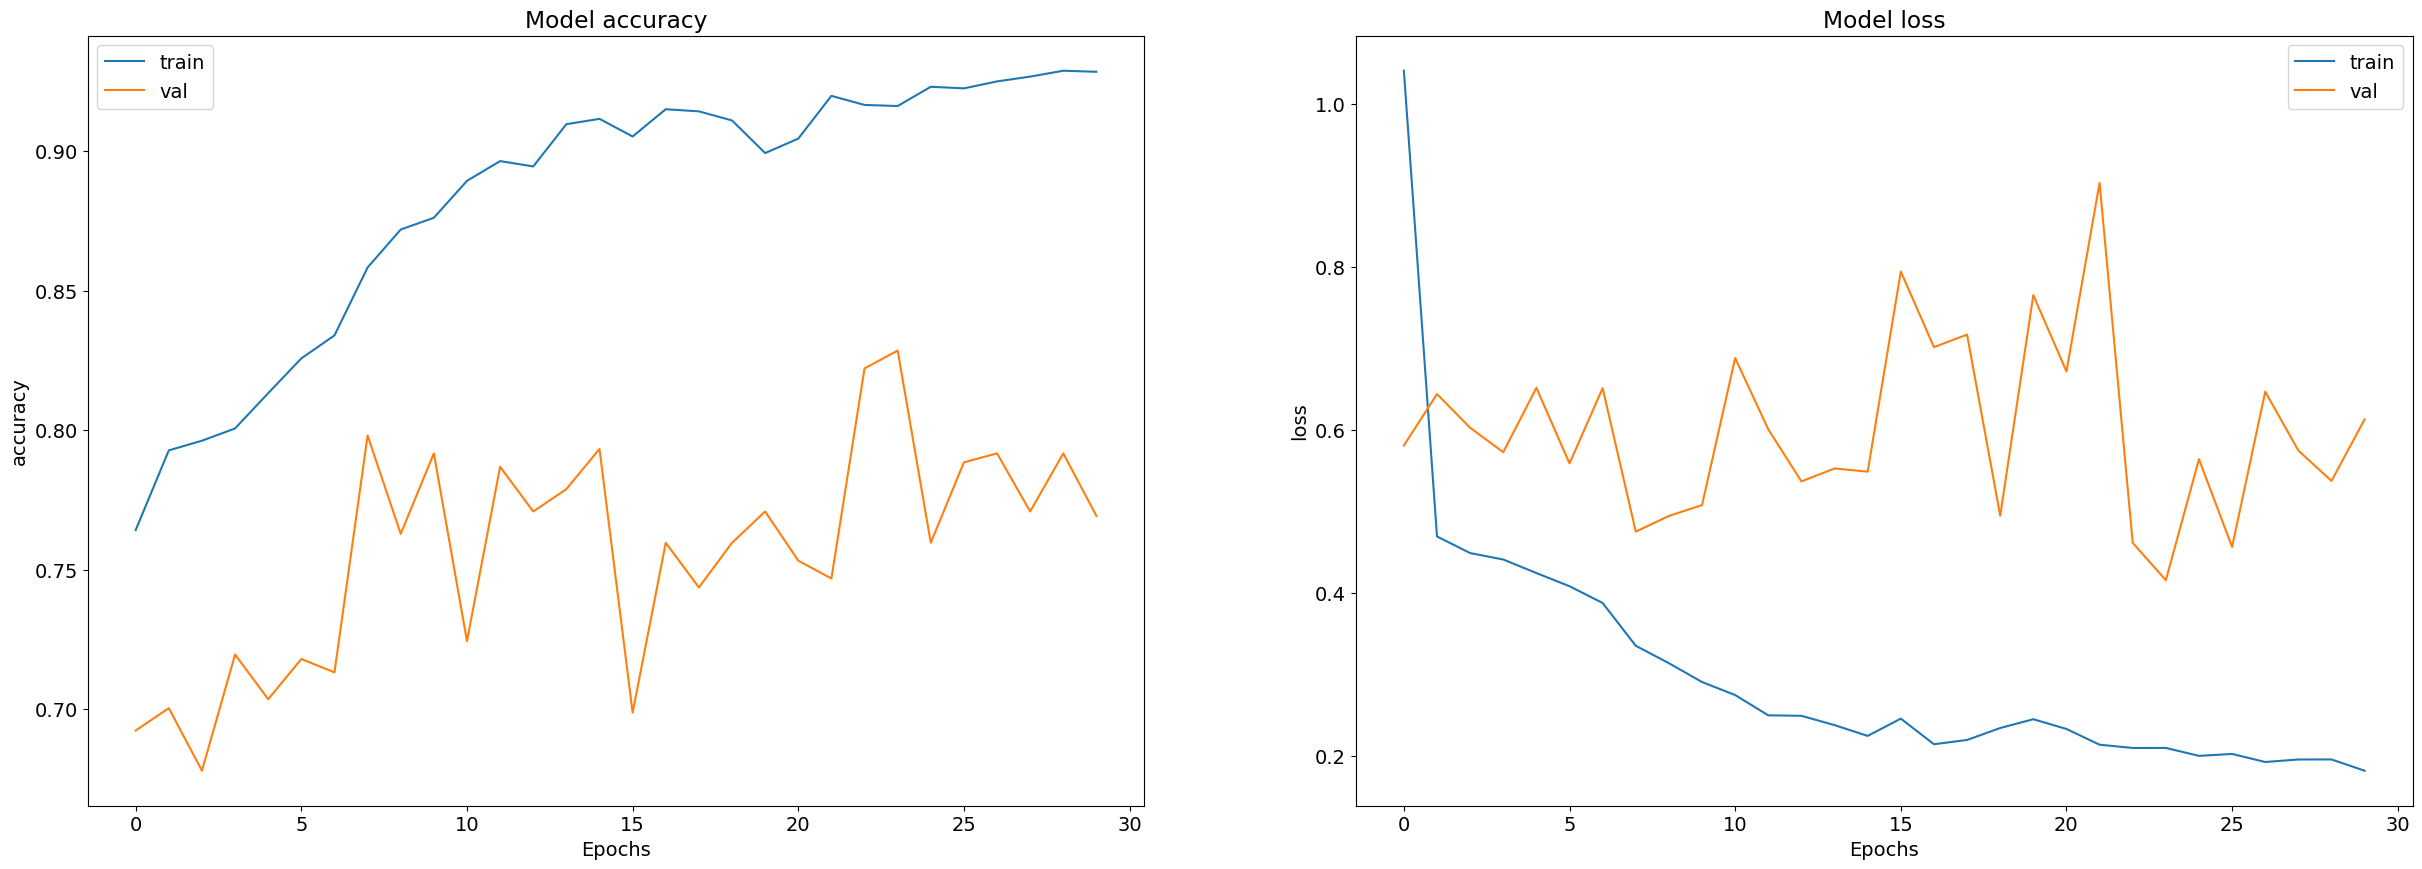

In [11]:
# Create a figure and two subplots, setting a larger figure size for clear visualisation.
cnn_fig, cnn_ax = plt.subplots(1, 2, figsize=(30, 10))
# Flatten the array of axes (subplot handlers) to make indexing easier.
cnn_ax = cnn_ax.ravel()

# Loop over each metric that needs to be plotted (accuracy and loss).
for i, metric in enumerate(["accuracy", "loss"]):
    # Plot the training history of the current metric on the ith subplot.
    cnn_ax[i].plot(cnn_history.history[metric])
    # Also, plot the validation history of the same metric.
    cnn_ax[i].plot(cnn_history.history["val_" + metric])
    # Set the title of the ith subplot to the name of the metric being plotted.
    cnn_ax[i].set_title("Model {}".format(metric))
    # Label the x-axis as 'Epochs'.
    cnn_ax[i].set_xlabel("Epochs")
    # Label the y-axis as the current metric (accuracy or loss).
    cnn_ax[i].set_ylabel(metric)
    # Add a legend to differentiate between training and validation data points.
    cnn_ax[i].legend(["train", "val"])

39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step


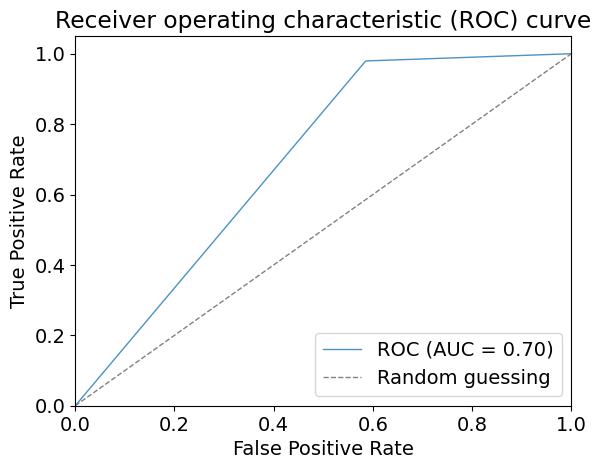

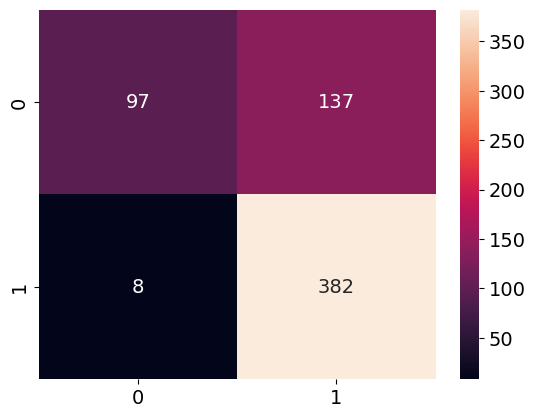

F1 Score: 0.8404840484048405


In [46]:
# Predict outcomes using the CNN model on the test dataset.
cnn_y_pred = cnn_model.predict(test_image_gen)
# Round the predictions to 0 or 1 since it's a binary classification.
cnn_y_pred = cnn_y_pred.round()
# Retrieve the true labels from the test data generator.
cnn_y_true = test_image_gen.classes

# Compute the false positive rate, true positive rate, and thresholds for the ROC curve.
cnn_fpr, cnn_tpr, cnn_thresholds = roc_curve(cnn_y_true, cnn_y_pred)
# Calculate the area under the ROC curve (AUC).
roc_auc = auc(cnn_fpr, cnn_tpr)
# Plot the ROC curve.
plt.plot(cnn_fpr, cnn_tpr, lw=1, alpha=0.8, label='ROC (AUC = %0.2f)' % (roc_auc))
# Plot the line of random guessing as a baseline comparison.
plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='gray', label='Random guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

# Compute the confusion matrix to evaluate accuracy.
cnn_cnf = confusion_matrix(cnn_y_true, cnn_y_pred)
# Plot the confusion matrix using a heatmap.
sns.heatmap(cnn_cnf, annot=True, fmt='g')
plt.show()

# Extract true positives, false positives, and false negatives from the confusion matrix for further metrics calculations.
cnn_TP = cnn_cnf[1, 1]
cnn_FP = cnn_cnf[0, 1]
cnn_FN = cnn_cnf[1, 0]
# Calculate precision, recall, and F1 score from the true positive, false positive, and false negative rates.
cnn_precision = cnn_TP / (cnn_TP + cnn_FP)
cnn_recall = cnn_TP / (cnn_TP + cnn_FN)
cnn_F1 = 2 * (cnn_precision * cnn_recall) / (cnn_precision + cnn_recall)

# Print the F1 score, which balances the precision and recall in a single metric.
print(f'F1 Score: {cnn_F1}')

----
VGG 16

In [13]:
# Load pre-trained VGG16 model without the top layer, using ImageNet weights, and custom input shape.
vgg = VGG16(input_shape=image_shape, weights='imagenet', include_top=False)

# Freeze the layers of the VGG16 model to prevent updates during training.
for layer in vgg.layers:
    layer.trainable = False

# Flatten the output of the VGG16 model to prepare for the fully connected layer.
vgg_x = Flatten()(vgg.output)

# Add a Dense output layer with a sigmoid activation for binary classification.
vgg_prediction = Dense(1, activation='sigmoid')(vgg_x)

# Assemble the final model from the VGG base and the new output layer.
vgg_model = Model(inputs=vgg.input, outputs=vgg_prediction)

In [14]:
# Compile the VGG-based model with the Adam optimizer, binary crossentropy loss, and accuracy metric.
vgg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
# Train the VGG-based model using the training generator, validate with the test generator, and apply early stopping.
vgg_history = vgg_model.fit(train_image_gen, epochs=30, validation_data=test_image_gen, callbacks=[early_stop])

Epoch 1/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 43s 127ms/step - accuracy: 0.8657 - loss: 1.6430 - val_accuracy: 0.7772 - val_loss: 3.4924
Epoch 2/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 42s 126ms/step - accuracy: 0.9411 - loss: 0.7892 - val_accuracy: 0.8205 - val_loss: 3.7120
Epoch 3/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 42s 127ms/step - accuracy: 0.9555 - loss: 0.6078 - val_accuracy: 0.8429 - val_loss: 2.8369
Epoch 4/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 42s 126ms/step - accuracy: 0.9497 - loss: 0.6748 - val_accuracy: 0.8253 - val_loss: 4.1179
Epoch 5/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 42s 126ms/step - accuracy: 0.9467 - loss: 0.8973 - val_accuracy: 0.7917 - val_loss: 6.7876
Epoch 6/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 42s 126ms/step - accuracy: 0.9567 - loss: 0.6980 - val_accuracy: 0.7708 - val_loss: 7.0009
Epoch 7/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 42s 126ms/step - accuracy: 0.9549 - loss: 0.7942 - val_accuracy: 0.7917 - val_loss: 7.3644
Epoch 8/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 42s 127ms/step - accuracy: 0.9647 - loss: 0

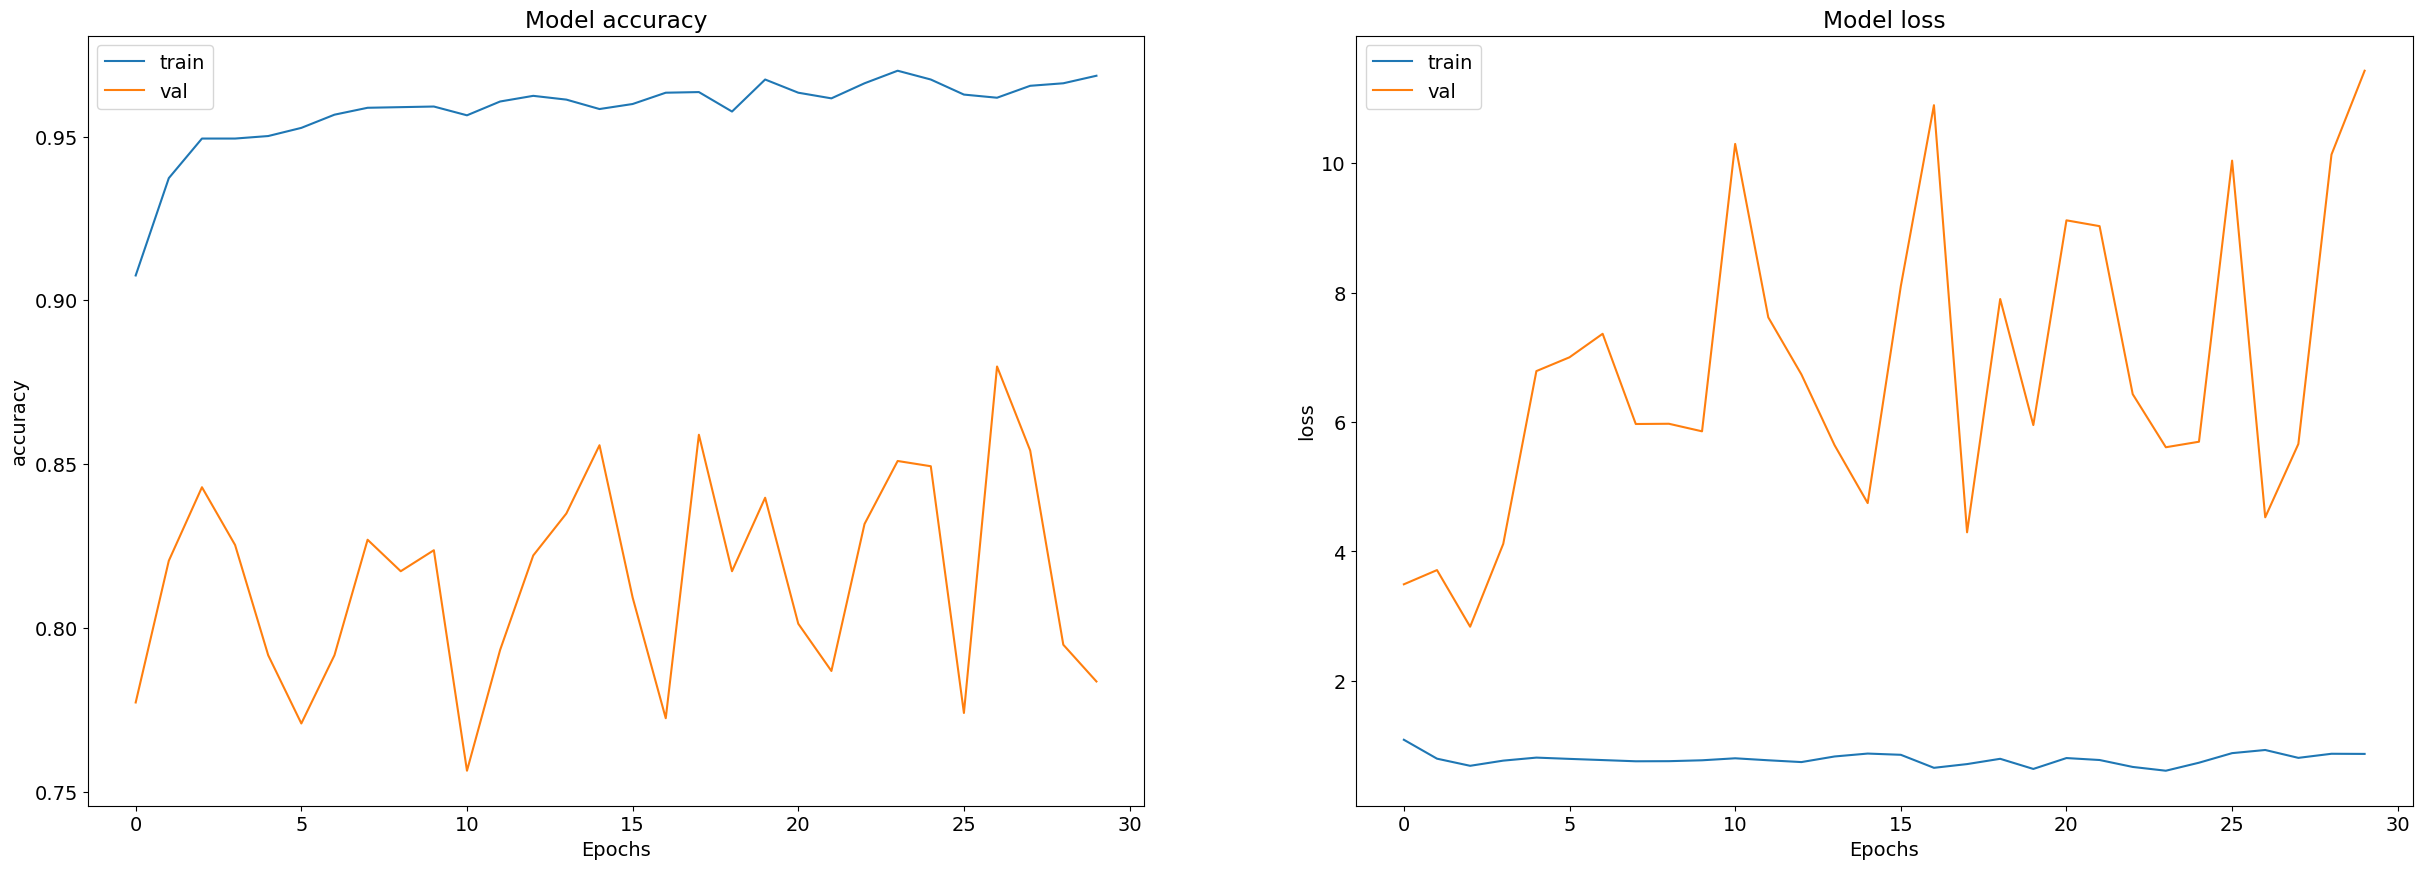

In [16]:
# Set up subplots for visualizing training metrics and flatten axis array for easy indexing.
vgg_fig, vgg_ax = plt.subplots(1, 2, figsize = (30, 10))
vgg_ax = vgg_ax.ravel()

# Loop through specified metrics to plot training and validation performance for each.
for i, metric in enumerate(["accuracy", "loss"]):
    vgg_ax[i].plot(vgg_history.history[metric])  # Plot training data.
    vgg_ax[i].plot(vgg_history.history["val_" + metric])  # Plot validation data.
    vgg_ax[i].set_title("Model {}".format(metric))  # Title with the current metric.
    vgg_ax[i].set_xlabel("Epochs")  # X-axis label.
    vgg_ax[i].set_ylabel(metric)  # Y-axis label.
    vgg_ax[i].legend(["train", "val"])  # Add legend to clarify plotted data.

39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step


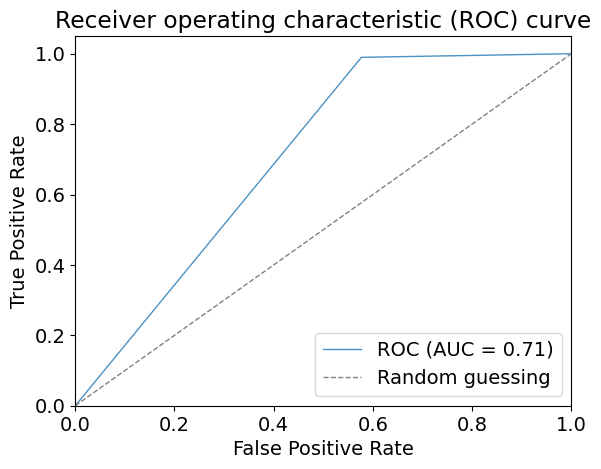

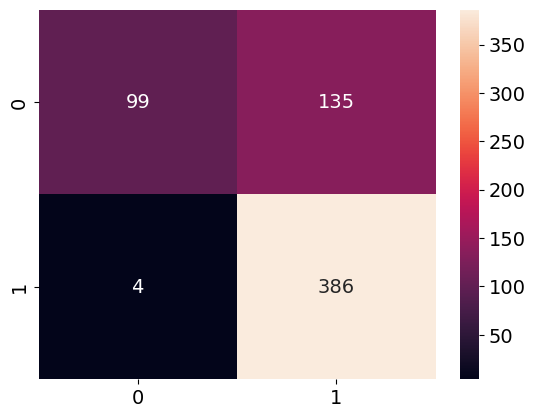

F1 Score: 0.8474204171240395


In [43]:
# Predict class probabilities, round to get binary class predictions, and fetch true class labels from the generator.
vgg_y_pred = vgg_model.predict(test_image_gen)
vgg_y_pred = vgg_y_pred.round()
vgg_y_true = test_image_gen.classes

# Compute ROC curve metrics and AUC for model evaluation.
vgg_fpr, vgg_tpr, vgg_thresholds = roc_curve(vgg_y_true, vgg_y_pred)
roc_auc = auc(vgg_fpr, vgg_tpr)
# Plot ROC curve and compare against random guessing.
plt.plot(vgg_fpr, vgg_tpr, lw=1, alpha=0.8, label='ROC (AUC = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='gray', label='Random guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

# Calculate and visualize the confusion matrix.
vgg_cnf = confusion_matrix(vgg_y_true, vgg_y_pred)
sns.heatmap(vgg_cnf, annot=True, fmt='g')
plt.show()

# Compute precision, recall, and F1 score from the confusion matrix.
vgg_TP = vgg_cnf[1, 1]  # True Positives
vgg_FP = vgg_cnf[0, 1]  # False Positives
vgg_FN = vgg_cnf[1, 0]  # False Negatives
vgg_precision = vgg_TP / (vgg_TP + vgg_FP)
vgg_recall = vgg_TP / (vgg_TP + vgg_FN)
vgg_F1 = 2 * (vgg_precision * vgg_recall) / (vgg_precision + vgg_recall)

# Output the F1 score, a harmonic mean of precision and recall.
print(f'F1 Score: {vgg_F1}')

___
resnet50

In [19]:
# Initialise the ResNet50 model with pre-trained ImageNet weights, excluding the top fully connected layers.
res = ResNet50(input_shape=image_shape, weights='imagenet', include_top=False)

# Freeze all layers in the ResNet50 model to maintain the pre-trained features.
for layer in res.layers:
    layer.trainable = False

# Flatten the output of the ResNet50 to prepare it for the fully connected classification layer.
res_x = Flatten()(res.output)

# Add a dense layer with one output unit and a sigmoid activation function for binary classification.
res_prediction = Dense(1, activation='sigmoid')(res_x)

# Create the final model by specifying the inputs and outputs, integrating the ResNet50 base and the new top layer.
res50_model = Model(inputs=res.input, outputs=res_prediction)


In [20]:
# Compile the ResNet50-based model with Adam optimizer, binary crossentropy as the loss function, and accuracy as a metric.
res50_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
# Train the model using the training data generator for 30 epochs, validate with the test data generator, and apply early stopping.
res50_history = res50_model.fit(train_image_gen, epochs=30, validation_data=test_image_gen, callbacks=[early_stop])

Epoch 1/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 46s 131ms/step - accuracy: 0.8752 - loss: 0.7986 - val_accuracy: 0.7772 - val_loss: 2.4537
Epoch 2/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 41s 123ms/step - accuracy: 0.9451 - loss: 0.3662 - val_accuracy: 0.8478 - val_loss: 1.5959
Epoch 3/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 42s 125ms/step - accuracy: 0.9330 - loss: 0.7207 - val_accuracy: 0.7372 - val_loss: 4.6911
Epoch 4/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 41s 124ms/step - accuracy: 0.9361 - loss: 0.6603 - val_accuracy: 0.7308 - val_loss: 5.7173
Epoch 5/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 41s 125ms/step - accuracy: 0.9557 - loss: 0.5062 - val_accuracy: 0.7596 - val_loss: 6.1517
Epoch 6/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 42s 125ms/step - accuracy: 0.9558 - loss: 0.6221 - val_accuracy: 0.7260 - val_loss: 6.1269
Epoch 7/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 42s 125ms/step - accuracy: 0.9579 - loss: 0.4392 - val_accuracy: 0.8317 - val_loss: 2.8495
Epoch 8/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 41s 125ms/step - accuracy: 0.9576 - loss: 0

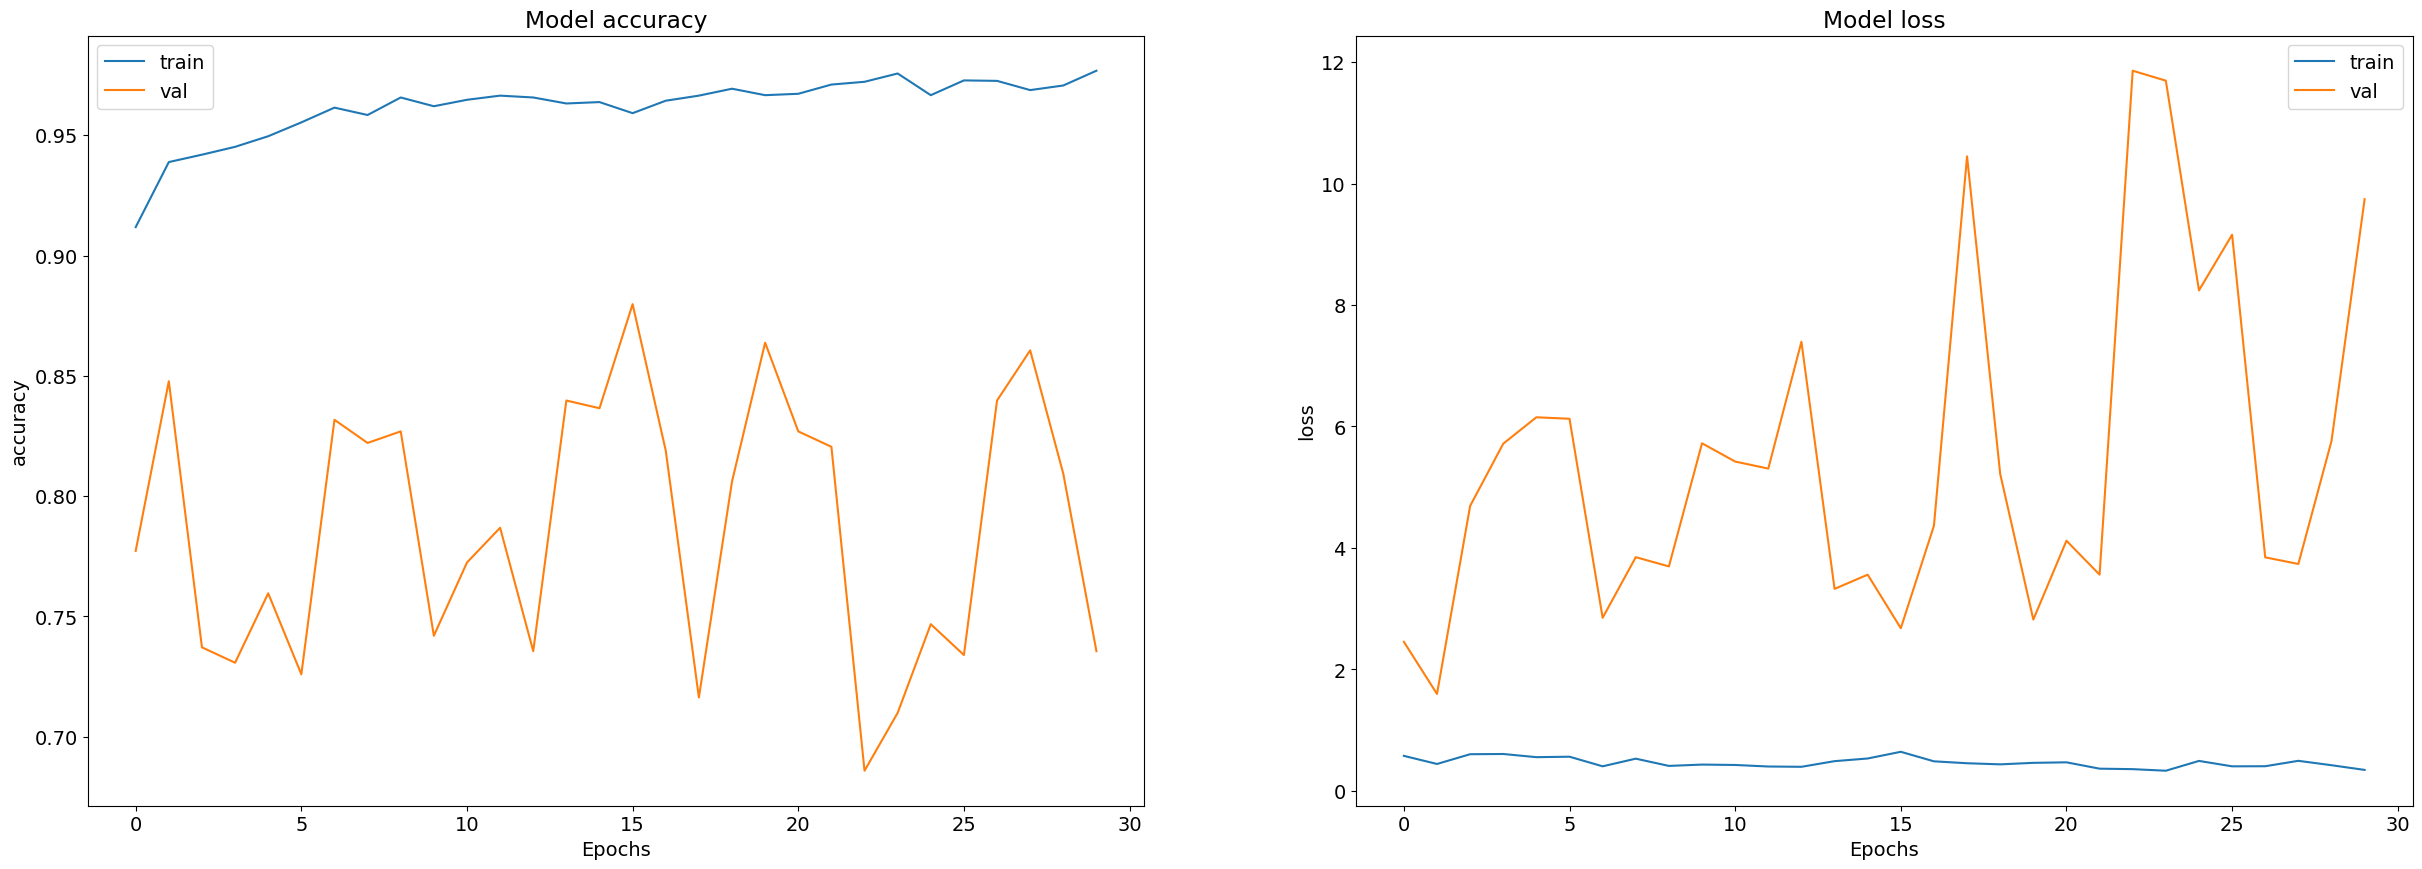

In [22]:
# Initialise a figure with two subplots for plotting training metrics, and flatten the axes array for easy indexing.
res50_fig, res50_ax = plt.subplots(1, 2, figsize = (30, 10))
res50_ax = res50_ax.ravel()

# Loop through and plot both accuracy and loss metrics from the model's training history on respective subplots.
for i, metric in enumerate(["accuracy", "loss"]):
    res50_ax[i].plot(res50_history.history[metric])  # Plot the training data for each metric.
    res50_ax[i].plot(res50_history.history["val_" + metric])  # Plot the validation data for each metric.
    res50_ax[i].set_title("Model {}".format(metric))  # Set the title of each subplot to the corresponding metric.
    res50_ax[i].set_xlabel("Epochs")  # Label the x-axis as 'Epochs'.
    res50_ax[i].set_ylabel(metric)  # Label the y-axis with the name of the metric.
    res50_ax[i].legend(["train", "val"])  # Add a legend to distinguish between training and validation data.

39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step


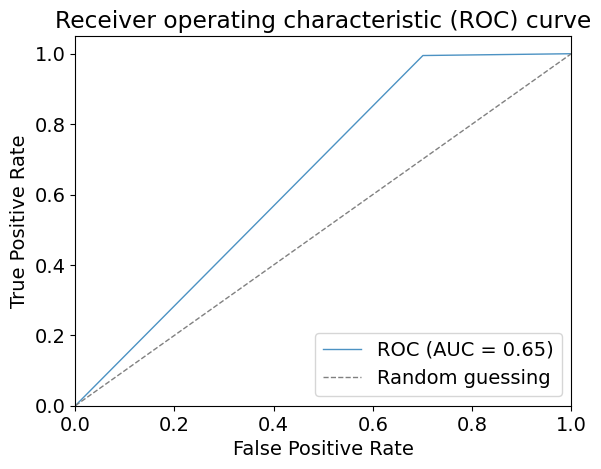

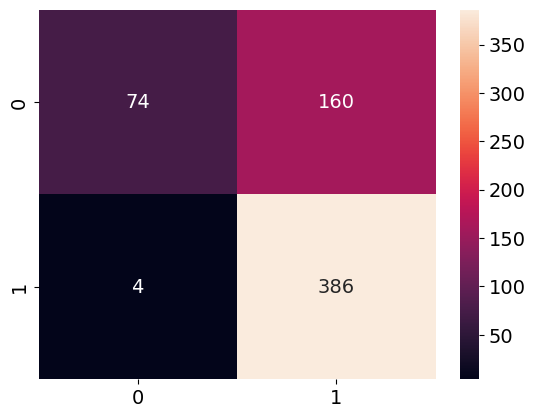

F1 Score: 0.8237791932059448


In [41]:
# Predict outcomes using the ResNet50 model on the test dataset, and round probabilities to derive final class predictions.
res50_y_pred = res50_model.predict(test_image_gen)
res50_y_pred = res50_y_pred.round()
res50_y_true = test_image_gen.classes  # Get true class labels for comparison.

# Compute ROC curve metrics and AUC to assess model performance.
res50_fpr, res50_tpr, res50_thresholds = roc_curve(res50_y_true, res50_y_pred)
roc_auc = auc(res50_fpr, res50_tpr)
# Plot ROC curve and a line for random guessing as a visual comparison.
plt.plot(res50_fpr, res50_tpr, lw=1, alpha=0.8, label='ROC (AUC = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='gray', label='Random guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

# Calculate and display the confusion matrix using a heatmap for better visualization.
res50_cnf = confusion_matrix(res50_y_true, res50_y_pred)
sns.heatmap(res50_cnf, annot=True, fmt='g')
plt.show()

# Calculate precision, recall, and F1 score from the confusion matrix.
res50_TP = res50_cnf[1, 1]  # True Positives
res50_FP = res50_cnf[0, 1]  # False Positives
res50_FN = res50_cnf[1, 0]  # False Negatives
res50_precision = res50_TP / (res50_TP + res50_FP)  # Precision calculation
res50_recall = res50_TP / (res50_TP + res50_FN)  # Recall calculation
res50_F1 = 2 * (res50_precision * res50_recall) / (res50_precision + res50_recall)  # F1 Score calculation

# Output the F1 score, which balances precision and recall.
print(f'F1 Score: {res50_F1}')

In [25]:
# Load the Models
# cnn_model = load_model("cnn_model.keras")
# res50_model = load_model("resnet50_model.keras")
# vgg_model = load_model("vgg_model.keras")

# Save Models
cnn_model.save("cnn_model.keras")
res50_model.save("resnet50_model.keras")
vgg_model.save("vgg_model.keras")

# Save Historys
with open('cnn_history.pickle', 'wb') as f:
    pickle.dump(cnn_history.history, f)
    
with open('res50_history.pickle', 'wb') as f:
    pickle.dump(res50_history.history, f)
    
with open('vgg_history.pickle', 'wb') as f:
    pickle.dump(vgg_history.history, f)

___
Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━

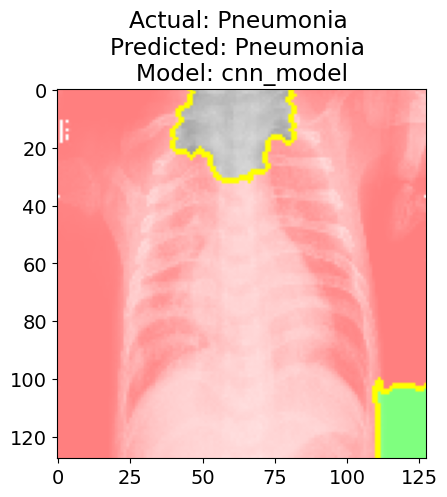

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━

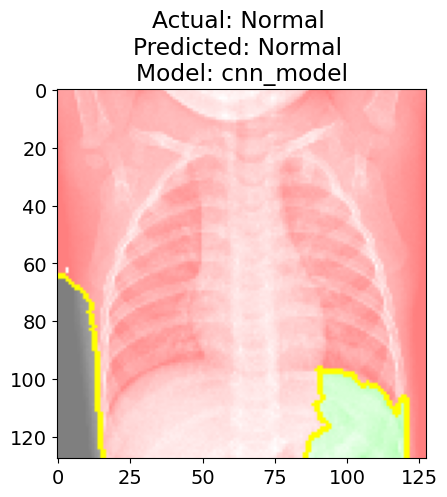

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━

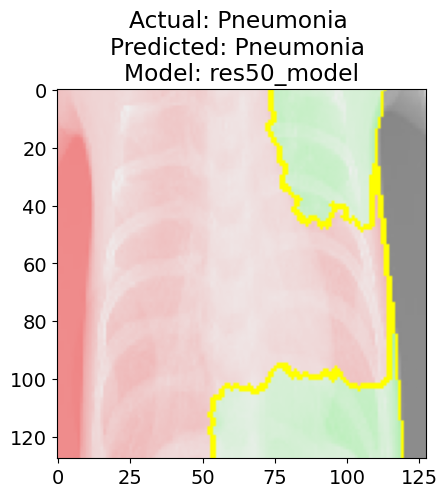

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━

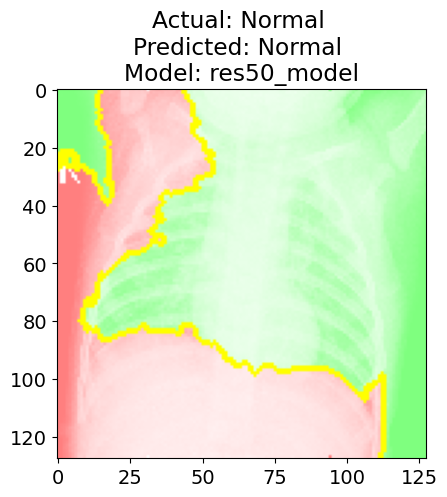

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━

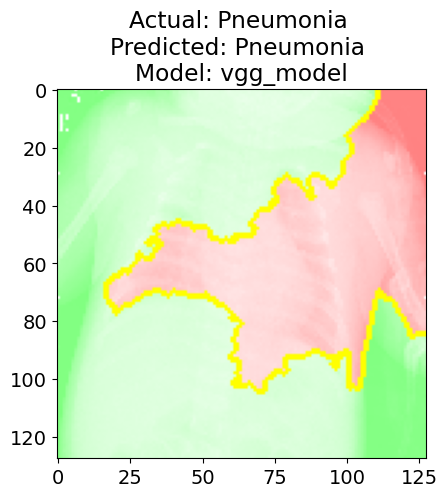

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━

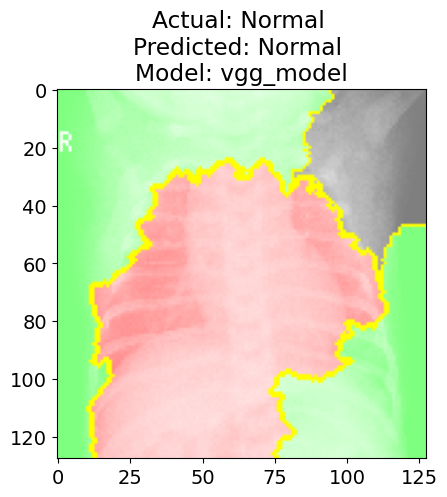

In [32]:
def load_and_preprocess_image(image_path, model_name):
    # Load image, resize to 128x128, and convert to array.
    img = load_img(image_path, target_size=(128, 128))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension.
    # Apply appropriate preprocessing depending on model type.
    if model_name.lower() == 'vgg' or model_name.lower() == 'resnet50':
        return preprocess_input(img_array)  # Preprocess for VGG/ResNet.
    else:
        return img_array / 255.0  # Normalize for custom models.

def label_to_string(label):
    # Convert binary label to string.
    return "Pneumonia" if label > 0.5 else "Normal"

def explain_model_prediction(image_path, model_path, model_name, actual_label):
    # Load and compile model.
    model = load_model(model_path)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    img_array = load_and_preprocess_image(image_path, model_name)  # Preprocess image.
    
    prediction = model.predict(img_array)  # Predict image class.
    predicted_label = (prediction > 0.5).astype(int)  # Determine predicted label.
    
    # Convert actual and predicted labels to strings.
    actual_label_str = label_to_string(actual_label)
    predicted_label_str = label_to_string(predicted_label[0][0])

    # Explain prediction using LIME.
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(img_array[0], model.predict, top_labels=1, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
    
    # Display explanation overlay on image.
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.title(f'Actual: {actual_label_str} \nPredicted: {predicted_label_str} \nModel: {model_name}')
    plt.show()
    
# Function calls to explain predictions on the pneumonia and three non pneumona images using all three models.
explain_model_prediction('chest_xray/chest_xray/train/PNEUMONIA/person1649_bacteria_4377.jpeg', 'cnn_model.keras', 'cnn_model', actual_label=1)
explain_model_prediction('chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-1303-0001.jpeg', 'cnn_model.keras', 'cnn_model', actual_label=0)
explain_model_prediction('chest_xray/chest_xray/train/PNEUMONIA/person1677_bacteria_4444.jpeg', 'resnet50_model.keras', 'res50_model', actual_label=1)
explain_model_prediction('chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-1401-0001.jpeg', 'resnet50_model.keras', 'res50_model', actual_label=0)
explain_model_prediction('chest_xray/chest_xray/train/PNEUMONIA/person1942_bacteria_4865.jpeg', 'vgg_model.keras', 'vgg_model', actual_label=1)
explain_model_prediction('chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-1419-0001.jpeg', 'vgg_model.keras', 'vgg_model', actual_label=0)

___
Model Comparison

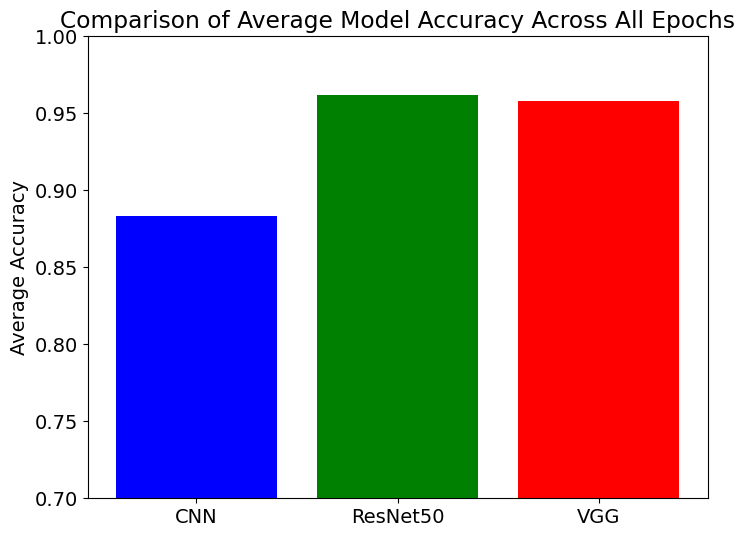

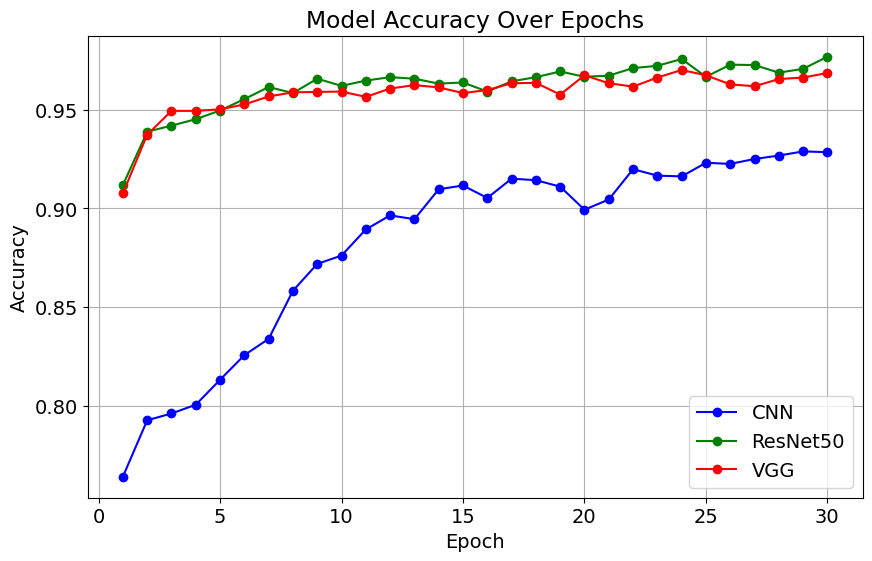

In [34]:
# Data for plotting
cnn_accuracy = cnn_history.history['accuracy']
res50_accuracy = res50_history.history['accuracy']
vgg_accuracy = vgg_history.history['accuracy']
epochs = range(1, 31)  # Epochs 1 through 30

# Calculate the average accuracies
cnn_avg_accuracy = np.mean(cnn_accuracy)
res50_avg_accuracy = np.mean(res50_accuracy)
vgg_avg_accuracy = np.mean(vgg_accuracy)

# Define colours for consistent use in plots
colors = {'CNN': 'blue', 'ResNet50': 'green', 'VGG': 'red'}

# Bar Chart for average epoch accuracy comparison
plt.figure(figsize=(8, 6))
plt.bar(['CNN', 'ResNet50', 'VGG'], 
        [cnn_avg_accuracy, res50_avg_accuracy, vgg_avg_accuracy], 
        color=[colors['CNN'], colors['ResNet50'], colors['VGG']])
plt.ylabel('Average Accuracy')
plt.title('Comparison of Average Model Accuracy Across All Epochs')
plt.ylim(0.7, 1) 
plt.show()

# Line plot for accuracy over epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, cnn_accuracy, 'o-', color=colors['CNN'], label='CNN')
plt.plot(epochs, res50_accuracy, 'o-', color=colors['ResNet50'], label='ResNet50')
plt.plot(epochs, vgg_accuracy, 'o-', color=colors['VGG'], label='VGG')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

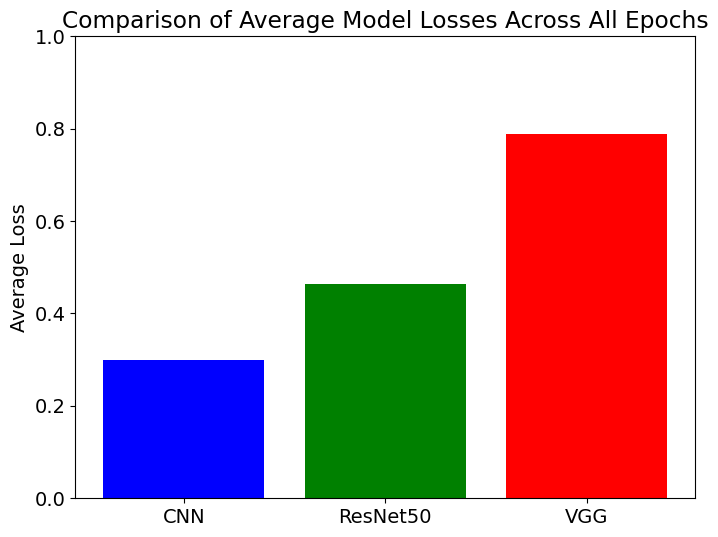

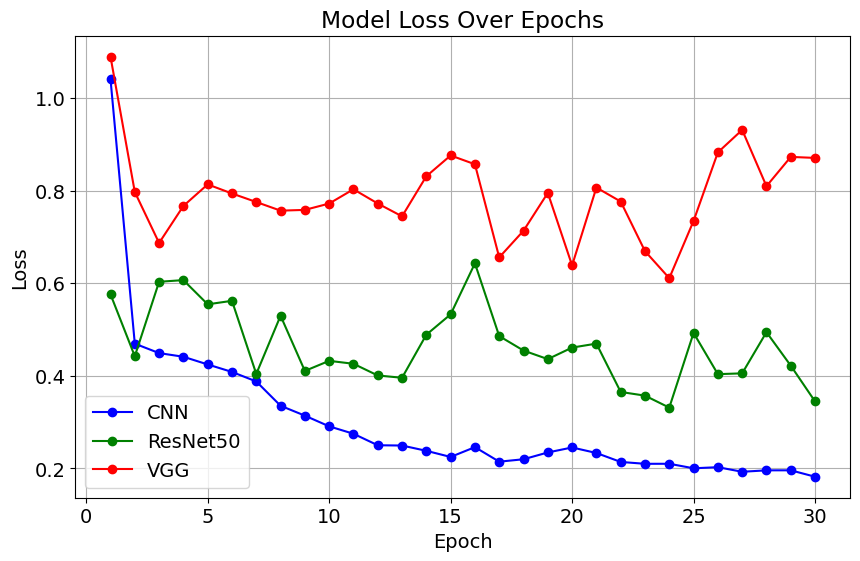

In [36]:
# Data for plotting
cnn_loss = cnn_history.history['loss']
res50_loss = res50_history.history['loss']
vgg_loss = vgg_history.history['loss']
epochs = range(1, 31)  # Epochs 1 through 30

# Calculate the average accuracies
cnn_avg_loss = np.mean(cnn_loss)
res50_avg_loss = np.mean(res50_loss)
vgg_avg_loss = np.mean(vgg_loss)

# Bar Chart for average epoch accuracy comparison
plt.figure(figsize=(8, 6))
plt.bar(['CNN', 'ResNet50', 'VGG'], 
        [cnn_avg_loss, res50_avg_loss, vgg_avg_loss], 
        color=[colors['CNN'], colors['ResNet50'], colors['VGG']])
plt.ylabel('Average Loss')
plt.title('Comparison of Average Model Losses Across All Epochs')
plt.ylim(0, 1)  # Adjust y-axis for better visual comparison
plt.show()

# Line plot for accuracy over epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, cnn_loss, 'o-', color=colors['CNN'], label='CNN')
plt.plot(epochs, res50_loss, 'o-', color=colors['ResNet50'], label='ResNet50')
plt.plot(epochs, vgg_loss, 'o-', color=colors['VGG'], label='VGG')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

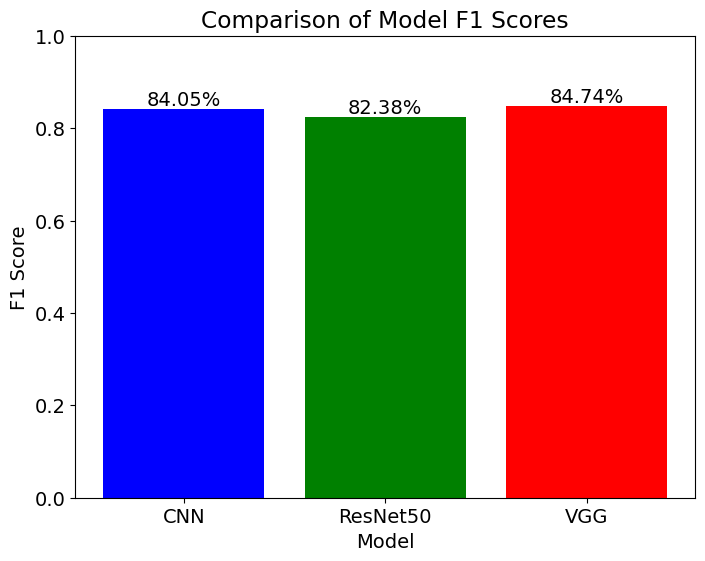

In [50]:
# Names of models
model_names = ['CNN', 'ResNet50', 'VGG']

# Corresponding F1 scores
f1_scores = [cnn_F1, res50_F1, vgg_F1]

# Create bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(model_names, f1_scores, color=['blue', 'green', 'red'])
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title('Comparison of Model F1 Scores')
plt.ylim(0, 1)  # F1 score ranges from 0 to 1

# Adding the percentage on the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2%}', va='bottom', ha='center')

plt.show()